# Import des jeux de données 

In [1]:
pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 40.5 MB/s 


In [2]:
import pandas as pd
import datetime
import glob
import json
import pickle
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics
import warnings
import statistics
from math import *
from scipy.stats import t, norm
from scipy import sqrt
#from lifelines import KaplanMeierFitter
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.model_selection import train_test_split, RepeatedKFold
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.exceptions import FitFailedWarning
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

In [3]:
Nsim=100

In [4]:
# import des tables
scen1=[]
folder_path = 'drive/MyDrive/scen1/10data/'
file_list = glob.glob(folder_path + "/*.csv")
for file in file_list:
  scen1_data = pd.read_csv(file)
  scen1.append(scen1_data)

In [ ]:
# sauvegarder les données en csv
  with open(f"drive/MyDrive/save_data/scenario1.csv", "wb") as fp: #Pickling
    pickle.dump(scen1, fp)

In [ ]:
# restitution de la liste
with open("drive/MyDrive/save_data/scenario1.csv", "rb") as fp:   # Unpickling
  scenario1 = pickle.load(fp)

In [5]:
scenario1 = scen1

# Taux de censure

In [6]:
# extrait des tables avant temps et statut vital
y=[]
for k in range(len(scenario1)):
  scenario1[k] = scenario1[k].rename(columns = {'y': 'days'})
  vector_y = scenario1[k].iloc[:,50:52]
  y.append(vector_y)

In [7]:
# Comptage du nombre de vivant et mort pour chaque jeux de données
décès = []
vivant = []

for tab in y:
  d1=tab["failed"].value_counts()[1]
  décès.append(d1)
  d2=tab["failed"].value_counts()[0]
  vivant.append(d2)

print(f"Pour chaque jeux de données, nous avons calculé le nombre de mort et le nombre de vivant, nous trouvons respectivement \n "
      f"{décès} et \n {vivant}")

Pour chaque jeux de données, nous avons calculé le nombre de mort et le nombre de vivant, nous trouvons respectivement 
 [982, 982, 1037, 1022, 1069, 1050, 996, 978, 995, 1001, 993, 950, 1000, 986, 1028, 1047, 974, 1027, 996, 982, 986, 1052, 999, 998, 978, 969, 1015, 1003, 1080, 1023, 938, 1016, 1005, 995, 1024, 998, 993, 990, 1000, 1009, 1002, 1000, 979, 990, 974, 993, 977, 975, 1013, 972, 984, 1019, 982, 1018, 1025, 981, 992, 991, 1023, 1019, 965, 1044, 1016, 1009, 1021, 971, 1010, 973, 1003, 995, 979, 965, 983, 982, 958, 958, 970, 997, 999, 999, 1043, 1005, 965, 1019, 973, 985, 953, 1004, 975, 951, 996, 960, 1046, 906, 981, 1056, 967, 968, 1030, 1016] et 
 [4018, 4018, 3963, 3978, 3931, 3950, 4004, 4022, 4005, 3999, 4007, 4050, 4000, 4014, 3972, 3953, 4026, 3973, 4004, 4018, 4014, 3948, 4001, 4002, 4022, 4031, 3985, 3997, 3920, 3977, 4062, 3984, 3995, 4005, 3976, 4002, 4007, 4010, 4000, 3991, 3998, 4000, 4021, 4010, 4026, 4007, 4023, 4025, 3987, 4028, 4016, 3981, 4018, 3982, 3975, 4

In [8]:
# taux de censure
tx_censures=[]
N=5000 #effectif 
for nb_vivant in range(len(vivant)):
  tx_censure = vivant[nb_vivant]/N
  tx_censures.append(tx_censure)

print(f"{statistics.mean(tx_censures)}+-{statistics.stdev(tx_censures)}")

0.800658+-0.005727290331863279


# Modélisation

## Cox sans sélection de variable 

In [9]:
# extraire les y et les transformer en dnarray
y2=[0 for k in range(len(y))]
aux=[0 for k in range(len(y))]
new_y=[0 for k in range(len(y))]
for k in range(len(y)):
  y[k] = y[k].reindex(columns=["failed", "days"])
  y2[k]=y[k].to_numpy()
  aux[k] = [(e1,e2) for e1,e2 in y2[k]]
  new_y[k] = np.array(aux[k], dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
new_y[0]

array([(False,  64.), ( True,   9.), (False, 100.), ..., ( True,  51.),
       ( True,  56.), (False, 100.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [10]:
X=[0 for i in range(len(scenario1))]
for x in range(len(scenario1)):
  X[x] = scenario1[x].iloc[:,0:50]

In [11]:
# coefficient des variables dans le modèle sans sélection de variables 
estimator = CoxPHSurvivalAnalysis()
list_coef = [] # on stocke la liste des coefficients de chaque modèle pour chaque dataframe
coef_statin = [] # on stocke tous les coefficients de la variable X_statin pour chaque dataframe
for data in range(len(scenario1)):
  estimator.fit(X[data], new_y[data])
  coef_statin.append(estimator.coef_[0])
  list_coef.append(estimator.coef_)

In [ ]:
# sauvegarder une liste dans un fichier
with open("drive/MyDrive/save_data/coef_statin/scen1/cox_normal.csv", "wb") as fp:   #Pickling
  pickle.dump(coef_statin, fp)

In [12]:
# restitution du jeux de données
with open("drive/MyDrive/save_data/coef_statin/scen1/cox_normal.csv", "rb") as fp:   # Unpickling
  coef_statin = pickle.load(fp)

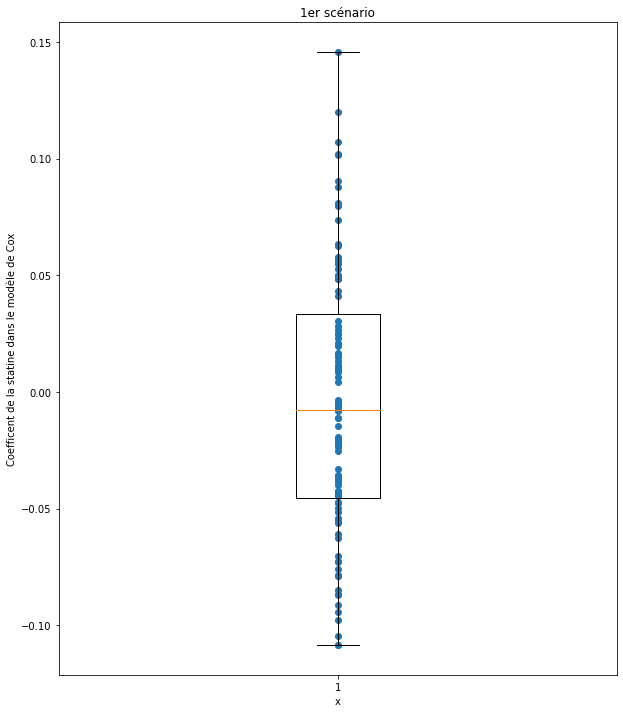

In [10]:
# boxplot de la distribution des coefficients de la statine
plt.figure(figsize =(10, 12))
plt.boxplot(coef_statin)
plt.scatter(x=[1 for i in range(len(list(coef_statin)))],y=list(coef_statin))
plt.title('1er scénario')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen1/coef_statine_normal1.png')

## Cox avec sélection de variable (via pénalité de Lasso)

In [6]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [13]:
Nsim = 100
list_cox_estimator = [ make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)) for k in range(Nsim)]

In [14]:
# Choix de la valeur de alpha pour le Lasso
# Utilisation de l'échantillon d'alphas et performance sur 5 blocs pour la validation croisée avec la métrique du C-index pour chaque alpha

list_estimated_alphas_lasso=[]
list_gcv_lasso=[]
for i in range(Nsim):
  list_cox_estimator[i].fit(X[i], new_y[i])
  list_estimated_alphas_lasso.append(list_cox_estimator[i].named_steps["coxnetsurvivalanalysis"].alphas_)
  cv_lasso = KFold(n_splits=5, shuffle=True, random_state=0)
  list_gcv_lasso.append(GridSearchCV(
    list_cox_estimator[i],
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in list_estimated_alphas_lasso[i]]},
    cv=cv_lasso,
    error_score=0.5, # score utilisé par défaut
    n_jobs=4).fit(X[i], new_y[i]))

In [15]:
# évaluation des alphas dans chaque bloc pour le maximiser
list_cv_results_lasso = []
for gcv_lasso in list_gcv_lasso:
  list_cv_results_lasso.append(pd.DataFrame(gcv_lasso.cv_results_))

In [ ]:
list_cv_results_lasso[0]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032860,0.010338,0.031088,0.004667,[0.07340710403922845],{'coxnetsurvivalanalysis__alphas': [0.07340710...,0.500000,0.603223,0.500000,0.598254,0.500000,0.540295,0.049377,6
1,0.022513,0.002718,0.026492,0.004881,[0.0700706378686602],{'coxnetsurvivalanalysis__alphas': [0.07007063...,0.664388,0.606038,0.652823,0.598254,0.661743,0.636649,0.028537,5
2,0.020282,0.004651,0.034514,0.002337,[0.06688581923483987],{'coxnetsurvivalanalysis__alphas': [0.06688581...,0.706272,0.639209,0.652823,0.618451,0.681380,0.659627,0.031008,4
3,0.024825,0.004449,0.029526,0.011724,[0.06384575552317881],{'coxnetsurvivalanalysis__alphas': [0.06384575...,0.744337,0.669011,0.654952,0.630280,0.696898,0.679095,0.039092,3
4,0.024449,0.007930,0.031307,0.004068,[0.060943867399059104],{'coxnetsurvivalanalysis__alphas': [0.06094386...,0.757656,0.706587,0.710591,0.653199,0.740377,0.713682,0.035677,2
5,0.025316,0.003864,0.025284,0.006875,[0.05817387456877533],{'coxnetsurvivalanalysis__alphas': [0.05817387...,0.774670,0.733260,0.741672,0.671340,0.774232,0.739035,0.037767,1


In [16]:
# lister les valeurs de alphas, moyenne et std de alphas pour chaque blocs
list_alphas_lasso=[]
list_mean_lasso=[]
list_std_lasso=[]
for cv_results_lasso in list_cv_results_lasso:
  list_alphas_lasso.append(cv_results_lasso.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0]))
  list_mean_lasso.append(cv_results_lasso.mean_test_score)
  list_std_lasso.append(cv_results_lasso.std_test_score)

In [17]:
# sélection de variable 
list_best_model_lasso = []
list_best_coefs_lasso = []
list_non_zero_lasso = []
list_non_zero_coefs_lasso = []
list_coef_order_lasso = []

for gcv_lasso in list_gcv_lasso:
  list_best_model_lasso.append(gcv_lasso.best_estimator_.named_steps["coxnetsurvivalanalysis"])

for  k in range(len(list_best_model_lasso)):
    list_best_coefs_lasso.append(pd.DataFrame(
    list_best_model_lasso[k].coef_,
    index=X[k].columns,
    columns=["coefficient"]))

# Donner le nombre de variable sélectionné pour chaque jeu de données et extraire les coefficients des variables sélectionnés 
for best_coefs_lasso in list_best_coefs_lasso:
  list_non_zero_lasso.append(np.sum(best_coefs_lasso.iloc[:, 0] != 0))
  list_non_zero_coefs_lasso.append(best_coefs_lasso.query("coefficient != 0"))

# Réordonner les variables sélectionnés par ordre croissant de leur coefficients (et cela pour chaque jeux de données)
for non_zero_coefs_lasso in list_non_zero_coefs_lasso:
  list_coef_order_lasso.append(non_zero_coefs_lasso.abs().sort_values("coefficient").index)

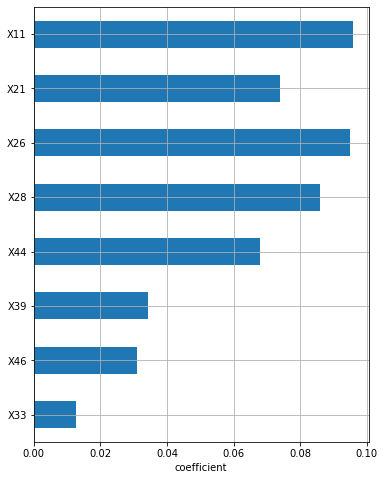

In [ ]:
# tracer les variables sélectionnées et leur coefficients
_, ax_lasso = plt.subplots(figsize=(6, 8))
list_graph_lasso = []
for non_zero_coefs_lasso, coef_order_lasso in zip(list_non_zero_coefs_lasso, list_coef_order_lasso):
  list_graph_lasso.append(non_zero_coefs_lasso.loc[coef_order_lasso].plot.barh(ax=ax_lasso, legend=False))
  ax_lasso.set_xlabel("coefficient")
  ax_lasso.grid(True)

In [18]:
# sélectionner les modèles qui ont sélectionné X_statin et énumérer les coefficients de X_statin
list_best_coefs_lasso_statin=[]
list_coef_xstatin = []
non_zero_coefs_lasso_statin = []
for i , best_coefs_lasso in enumerate(list_best_coefs_lasso):
  list_coef_xstatin.append(best_coefs_lasso.iloc[0,0])
  non_zero_coefs_lasso_statin.append(best_coefs_lasso.query("coefficient != 0"))
  if best_coefs_lasso.iloc[0,0] !=0:
    list_best_coefs_lasso_statin.append(best_coefs_lasso)
    print(f"la table {i+1} sélectionne X_statin")
  else:
    print(f"la table {i+1} ne sélectionne pas X_statin")

la table 1 ne sélectionne pas X_statin
la table 2 ne sélectionne pas X_statin
la table 3 ne sélectionne pas X_statin
la table 4 ne sélectionne pas X_statin
la table 5 ne sélectionne pas X_statin
la table 6 ne sélectionne pas X_statin
la table 7 ne sélectionne pas X_statin
la table 8 ne sélectionne pas X_statin
la table 9 ne sélectionne pas X_statin
la table 10 ne sélectionne pas X_statin
la table 11 ne sélectionne pas X_statin
la table 12 ne sélectionne pas X_statin
la table 13 ne sélectionne pas X_statin
la table 14 ne sélectionne pas X_statin
la table 15 ne sélectionne pas X_statin
la table 16 ne sélectionne pas X_statin
la table 17 ne sélectionne pas X_statin
la table 18 ne sélectionne pas X_statin
la table 19 ne sélectionne pas X_statin
la table 20 ne sélectionne pas X_statin
la table 21 ne sélectionne pas X_statin
la table 22 ne sélectionne pas X_statin
la table 23 ne sélectionne pas X_statin
la table 24 ne sélectionne pas X_statin
la table 25 ne sélectionne pas X_statin
la table 

In [ ]:
## déterminer le pourcentage d'apparition et le coefficients pour chaque X_statin

## pourcentage d'apparition pour chaque X_statin 

## sauvegarder la liste des coefficients de la statine
with open(f"drive/MyDrive/save_data/coef_statin/scen1/cox_lasso.csv", "wb") as fp: #Pickling
    pickle.dump(list_coef_xstatin, fp)

In [19]:
# restitution du jeux de données
with open("drive/MyDrive/save_data/coef_statin/scen1/cox_lasso.csv", "rb") as fp:   # Unpickling
  coef_statin = pickle.load(fp)

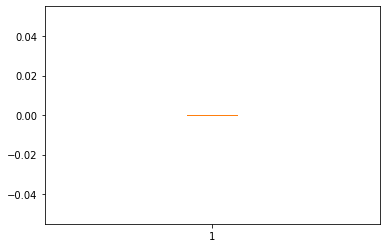

In [27]:
## coefficient de chaque X_statin
coef_statin
plt.boxplot(coef_statin)
plt.savefig('drive/MyDrive/save_data/coef_statin/scen1/coef_statine_lasso1.png')

## Modèle de Cox avec pénalité Elastic-net 

In [20]:
list_cox_estimator_elastic_net = [ make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)) for k in range(Nsim)]

In [21]:
# Choix de la valeur de alpha
# Utilisation de l'échantillon d'alphas et performance sur 5 blocs pour la validation croisée avec la métrique du C-index pour chaque alpha

list_estimated_alphas_elastic_net=[]
list_gcv_elastic_net=[]
Nsim=100
for i in range(Nsim):
  list_cox_estimator_elastic_net[i].fit(X[i], new_y[i])
  list_estimated_alphas_elastic_net.append(list_cox_estimator_elastic_net[i].named_steps["coxnetsurvivalanalysis"].alphas_)
  cv_elastic_net = KFold(n_splits=5, shuffle=True, random_state=0)
  list_gcv_elastic_net.append(GridSearchCV(
    list_cox_estimator_elastic_net[i],
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in list_estimated_alphas_elastic_net[i]], "coxnetsurvivalanalysis__l1_ratio": np.arange(0.1,1.0,0.1)},
    cv=cv_elastic_net,
    error_score=0.5, # score utilisé par défaut
    n_jobs=4).fit(X[i], new_y[i]))

In [22]:
# évaluation des alphas dans chaque bloc pour le maximiser
list_cv_results_elastic_net = []
for gcv_elastic_net in list_gcv_elastic_net:
  list_cv_results_elastic_net.append(pd.DataFrame(gcv_elastic_net.cv_results_))

In [23]:
list_cv_results_elastic_net[0]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,param_coxnetsurvivalanalysis__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.083108,0.031900,0.023435,0.009841,[0.08156344893247607],0.1,{'coxnetsurvivalanalysis__alphas': [0.08156344...,0.856367,0.847591,0.867905,0.864865,0.875157,0.862377,0.009538,5
1,0.089732,0.012722,0.021083,0.007508,[0.08156344893247607],0.2,{'coxnetsurvivalanalysis__alphas': [0.08156344...,0.855347,0.845822,0.865190,0.862169,0.873109,0.860327,0.009226,12
2,0.089204,0.014488,0.022932,0.004663,[0.08156344893247607],0.3,{'coxnetsurvivalanalysis__alphas': [0.08156344...,0.852683,0.842547,0.861474,0.857138,0.869435,0.856655,0.008962,18
3,0.060342,0.004495,0.021996,0.005427,[0.08156344893247607],0.4,{'coxnetsurvivalanalysis__alphas': [0.08156344...,0.847772,0.838246,0.852034,0.846760,0.861481,0.849259,0.007574,24
4,0.044976,0.006657,0.022099,0.003629,[0.08156344893247607],0.5,{'coxnetsurvivalanalysis__alphas': [0.08156344...,0.838979,0.826537,0.836962,0.827619,0.847252,0.835469,0.007678,31
5,0.033379,0.006565,0.025813,0.006708,[0.08156344893247607],0.6,{'coxnetsurvivalanalysis__alphas': [0.08156344...,0.819238,0.798922,0.810458,0.782754,0.825599,0.807394,0.015232,38
6,0.017575,0.001160,0.025270,0.004189,[0.08156344893247607],0.7,{'coxnetsurvivalanalysis__alphas': [0.08156344...,0.782672,0.741558,0.749149,0.684351,0.787128,0.748972,0.036939,45
7,0.011191,0.002719,0.028683,0.006798,[0.08156344893247607],0.8,{'coxnetsurvivalanalysis__alphas': [0.08156344...,0.727614,0.654539,0.652823,0.626926,0.690104,0.670401,0.034963,51
8,0.009645,0.003137,0.024318,0.003676,[0.08156344893247607],0.9,{'coxnetsurvivalanalysis__alphas': [0.08156344...,0.500000,0.603851,0.500000,0.598254,0.500000,0.540421,0.049537,54
9,0.091944,0.003286,0.021074,0.002621,[0.07785626429851135],0.1,{'coxnetsurvivalanalysis__alphas': [0.07785626...,0.856242,0.847633,0.867804,0.864955,0.875125,0.862352,0.009525,6


In [24]:
# lister les valeurs de alphas, lambda, moyenne et écart-type de alphas pour chaque blocs
list_alphas_elastic_net=[]
list_l1_ratio_elastic_net=[]
list_mean_elastic_net=[]
list_std_elastic_net=[]
for cv_results_elastic_net in list_cv_results_elastic_net:
  list_alphas_elastic_net.append(cv_results_elastic_net.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0]))
  list_l1_ratio_elastic_net.append(cv_results_elastic_net.param_coxnetsurvivalanalysis__l1_ratio)
  list_mean_elastic_net.append(cv_results_elastic_net.mean_test_score)
  list_std_elastic_net.append(cv_results_elastic_net.std_test_score)

In [25]:
# sélection de variable 
list_best_model_elastic_net = []
list_best_coefs_elastic_net = []
list_non_zero_elastic_net = []
list_non_zero_coefs_elastic_net = []
list_coef_order_elastic_net = []

for gcv_elastic_net in list_gcv_elastic_net:
  list_best_model_elastic_net.append(gcv_elastic_net.best_estimator_.named_steps["coxnetsurvivalanalysis"])

for  k in range(len(list_best_model_elastic_net)):
    list_best_coefs_elastic_net.append(pd.DataFrame(
    list_best_model_elastic_net[k].coef_,
    index=X[k].columns,
    columns=["coefficient"]))

# Donner le nombre de variable sélectionné pour chaque jeu de données et extraire les coefficients des variables sélectionnés 
for best_coefs_elastic_net in list_best_coefs_elastic_net:
  list_non_zero_elastic_net.append(np.sum(best_coefs_elastic_net.iloc[:, 0] != 0))
  list_non_zero_coefs_elastic_net.append(best_coefs_elastic_net.query("coefficient != 0"))

# Réordonner les variables sélectionnés par ordre croissant de leur coefficients (et cela pour chaque jeux de données)
for non_zero_coefs_elastic_net in list_non_zero_coefs_elastic_net:
  list_coef_order_elastic_net.append(non_zero_coefs_elastic_net.abs().sort_values("coefficient").index)

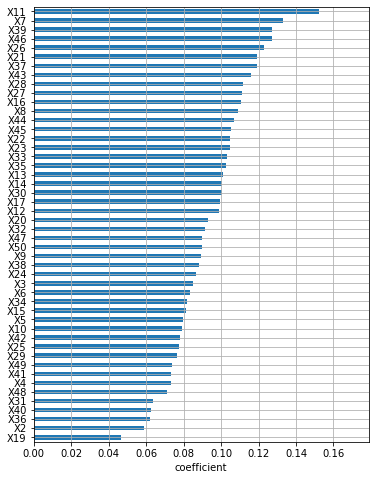

In [36]:
# tracer les variables sélectionnées et leur coefficients
_, ax_elastic_net = plt.subplots(figsize=(6, 8))
list_graph_elastic_net = []
for non_zero_coefs_elastic_net, coef_order_elastic_net in zip(list_non_zero_coefs_elastic_net, list_coef_order_elastic_net):
  list_graph_elastic_net.append(non_zero_coefs_elastic_net.loc[coef_order_elastic_net].plot.barh(ax=ax_elastic_net, legend=False))
  ax_elastic_net.set_xlabel("coefficient")
  ax_elastic_net.grid(True)

In [26]:
# sélectionner les modèles qui ont sélectionné X_statin et énumérer les coefficients de X_statin
list_best_coefs_elastic_net_statin=[]
list_coef_xstatin_elastic_net = []
non_zero_coefs_elastic_net_statin = []
count = 0
for i , best_coefs_elastic_net in enumerate(list_best_coefs_elastic_net):
  non_zero_coefs_elastic_net_statin.append(best_coefs_elastic_net.query("coefficient != 0"))
  if best_coefs_elastic_net.iloc[0,0] !=0:
    list_coef_xstatin_elastic_net.append(best_coefs_elastic_net.iloc[0,0])
    list_best_coefs_elastic_net_statin.append(best_coefs_elastic_net)
    count = count +1
    print(f"la table {i+1} sélectionne X_statin")
  else:
    print(f"la table {i+1} ne sélectionne pas X_statin")

la table 1 ne sélectionne pas X_statin
la table 2 sélectionne X_statin
la table 3 sélectionne X_statin
la table 4 sélectionne X_statin
la table 5 ne sélectionne pas X_statin
la table 6 sélectionne X_statin
la table 7 sélectionne X_statin
la table 8 sélectionne X_statin
la table 9 ne sélectionne pas X_statin
la table 10 ne sélectionne pas X_statin
la table 11 sélectionne X_statin
la table 12 ne sélectionne pas X_statin
la table 13 ne sélectionne pas X_statin
la table 14 sélectionne X_statin
la table 15 ne sélectionne pas X_statin
la table 16 sélectionne X_statin
la table 17 ne sélectionne pas X_statin
la table 18 sélectionne X_statin
la table 19 sélectionne X_statin
la table 20 ne sélectionne pas X_statin
la table 21 ne sélectionne pas X_statin
la table 22 sélectionne X_statin
la table 23 sélectionne X_statin
la table 24 ne sélectionne pas X_statin
la table 25 sélectionne X_statin
la table 26 ne sélectionne pas X_statin
la table 27 ne sélectionne pas X_statin
la table 28 ne sélectionne 

In [27]:
print(f"elastic-net permet de sélectionner {count}")

elastic-net permet de sélectionner 50


In [ ]:
## déterminer le pourcentage d'apparition et le coefficients pour chaque X_statin

## pourcentage d'apparition pour chaque X_statin 

## sauvegarder la liste des coefficients de la statine
with open(f"drive/MyDrive/save_data/coef_statin/scen1/cox_elastic-net.csv", "wb") as fp: #Pickling
    pickle.dump(list_coef_xstatin_elastic_net, fp)

In [28]:
# restitution du jeux de données
with open("drive/MyDrive/save_data/coef_statin/scen1/cox_elastic-net.csv", "rb") as fp:   # Unpickling
  list_coef_xstatin_elastic_net = pickle.load(fp)

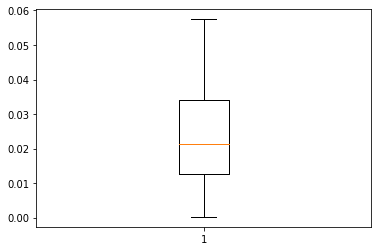

In [33]:
## coefficient de chaque X_statin
list_coef_xstatin_elastic_net
plt.boxplot(list_coef_xstatin_elastic_net)
plt.savefig('drive/MyDrive/save_data/coef_statin/scen1/coef_statine_elastic-net1.png')

In [ ]:
list_coef_xstatin_elastic_net

## Evaluation de la performance du modèle 

### C-index (indice de concordance)

***Sans sélection de variable***

In [ ]:
# declare the outer validation cross strategie
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

# create model
model = CoxPHSurvivalAnalysis()

# c'est là, qu'on évalue le modèle 
test_score_normal = []
for k in range(Nsim):
  test_score_normal.append(cross_val_score(model, X[k], new_y[k], cv=outer_cv, n_jobs=2))
  #print(f"The mean score using nested cross-validation for the {k+1} model is: \n "
      #f"{test_score_normal[k].mean():.3f} ± {test_score_normal[k].std():.3f}")

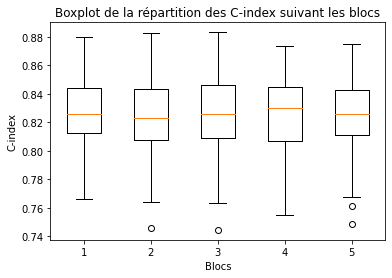

In [ ]:
import numpy
KFold1 = []
KFold2 = []
KFold3 = []
KFold4 = []
KFold5 = []

for k in range(Nsim):
  KFold1.append(test_score_normal[k][0])
  KFold2.append(test_score_normal[k][1])
  KFold3.append(test_score_normal[k][2])
  KFold4.append(test_score_normal[k][3])
  KFold5.append(test_score_normal[k][4])

plt.boxplot([KFold1, KFold2, KFold3, KFold4, KFold5])
plt.title('scénario 1')
plt.xlabel('Blocs')
plt.ylabel('C-index')

plt.savefig('drive/MyDrive/save_data/C-index/scen1/c-index1.png')

In [ ]:
for k in range(Nsim):
  print(f"Les listes de C-index sont {list(test_score_normal[k])}. \n")

***Avec pénalité de Lasso***

In [ ]:
# Outer cross-validation to compute the testing score
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
# c'est là, qu'on évalue le modèle 
test_score_lasso = []
for k in range(Nsim):
  test_score_lasso.append(cross_val_score(list_best_model_lasso[k], X[k], new_y[k], cv=outer_cv, n_jobs=2))
  #print(f"The mean score using nested cross-validation for the {k+1} model is: \n"
      #f"{test_score_lasso[k].mean():.3f} ± {test_score_lasso[k].std():.3f}")

In [ ]:
# calcul de la moyenne des C-index pour chaque modèle avec pénalité Lasso
C_index_mean_lasso = []
for i in range(Nsim):
  C_index_mean_lasso.append(statistics.mean(list(test_score_lasso[i])))

In [ ]:
list_best_model_lasso[0].alphas_
list_alphas_c_index_lasso = []
for i in range(Nsim):
  list_alphas_c_index_lasso.append(statistics.mean(list(list_best_model_lasso[i].alphas_)))

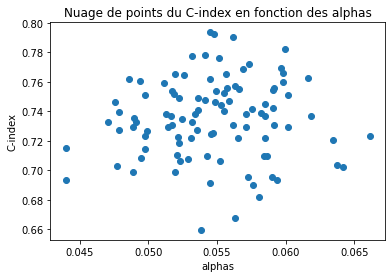

In [ ]:
plt.scatter(list_alphas_c_index_lasso, C_index_mean_lasso)
plt.title('Nuage de points du C-index en fonction des alphas')
plt.xlabel('alphas')
plt.ylabel('C-index')
plt.savefig('C-index et alphas 1.png')
plt.show()

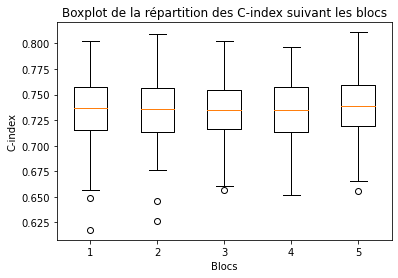

In [ ]:
KFold1_lasso = []
KFold2_lasso = []
KFold3_lasso = []
KFold4_lasso = []
KFold5_lasso = []

for k in range(Nsim):
  KFold1_lasso.append(test_score_lasso[k][0])
  KFold2_lasso.append(test_score_lasso[k][1])
  KFold3_lasso.append(test_score_lasso[k][2])
  KFold4_lasso.append(test_score_lasso[k][3])
  KFold5_lasso.append(test_score_lasso[k][4])

plt.boxplot([KFold1_lasso, KFold2_lasso, KFold3_lasso, KFold4_lasso, KFold5_lasso])
plt.title('Boxplot de la répartition des C-index suivant les blocs')
plt.xlabel('Blocs')
plt.ylabel('C-index')

plt.savefig('drive/MyDrive/save_data/C-index/scen1/c-index_lasso1.png')

***Avec pénalité Elastic-net***

In [ ]:
# c'est là, qu'on évalue le modèle 
test_score_elastic_net = []
for k in range(Nsim):
  test_score_elastic_net.append(cross_val_score(list_best_model_elastic_net[k], X[k], new_y[k], cv=outer_cv, n_jobs=2))
  #print(f"The mean score using nested cross-validation for the {k+1} model is: \n"
      #f"{test_score_lasso[k].mean():.3f} ± {test_score_lasso[k].std():.3f}")

In [ ]:
# calcul de la moyenne des C-index pour chaque modèle avec pénalité Elastic-net
C_index_mean_elastic_net = []
for i in range(Nsim):
  C_index_mean_elastic_net.append(statistics.mean(list(test_score_elastic_net[i])))

In [ ]:
# obtenir des alphas 
list_best_model_elastic_net[0].alphas_
list_alphas_c_index_elastic_net = []
for i in range(Nsim):
  list_alphas_c_index_elastic_net.append(statistics.mean(list_best_model_elastic_net[i].alphas_))

In [ ]:
# obtenir des lambda (l1-ratio)
list_lambda_c_index_elastic_net = []
for i in range(Nsim):
  list_lambda_c_index_elastic_net.append(list_best_model_elastic_net[i].l1_ratio)

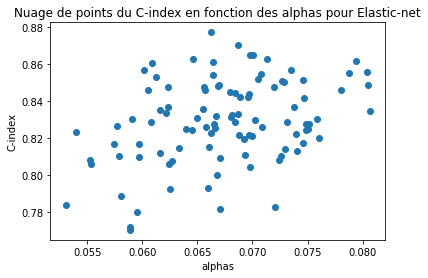

In [ ]:
plt.scatter(list_alphas_c_index_elastic_net, C_index_mean_elastic_net)
plt.title('Nuage de points du C-index en fonction des alphas pour Elastic-net')
plt.xlabel('alphas')
plt.ylabel('C-index')
plt.savefig('C-index et alphas-Elastic-net_1.png')
plt.show()

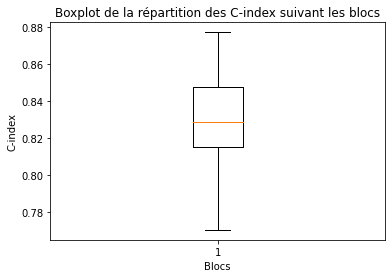

In [ ]:
plt.boxplot([C_index_mean_elastic_net])
plt.title('Boxplot de la répartition des C-index suivant les blocs')
plt.xlabel('Blocs')
plt.ylabel('C-index')

plt.savefig('drive/MyDrive/save_data/C-index/scen1/c-index_lasso1.png')

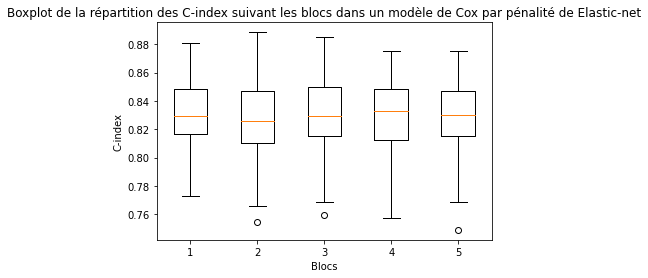

In [ ]:
KFold1_elastic_net = []
KFold2_elastic_net = []
KFold3_elastic_net = []
KFold4_elastic_net = []
KFold5_elastic_net = []

for k in range(Nsim):
  KFold1_elastic_net.append(test_score_elastic_net[k][0])
  KFold2_elastic_net.append(test_score_elastic_net[k][1])
  KFold3_elastic_net.append(test_score_elastic_net[k][2])
  KFold4_elastic_net.append(test_score_elastic_net[k][3])
  KFold5_elastic_net.append(test_score_elastic_net[k][4])

plt.boxplot([KFold1_elastic_net, KFold2_elastic_net, KFold3_elastic_net, KFold4_elastic_net, KFold5_elastic_net])
plt.title('Boxplot de la répartition des C-index suivant les blocs dans un modèle de Cox par pénalité de Elastic-net')
plt.xlabel('Blocs')
plt.ylabel('C-index')

plt.savefig('drive/MyDrive/save_data/C-index/scen1/c-index_elastic_net1.png')

### Courbe d'apprentissage 

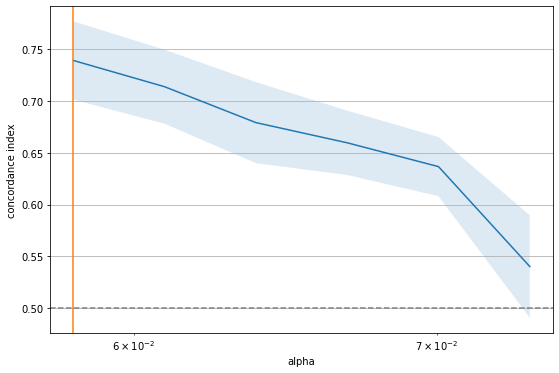

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(list_alphas_lasso[0], list_mean_lasso[0])
ax.fill_between(list_alphas_lasso[0], list_mean_lasso[0] - list_std_lasso[0], list_mean_lasso[0] + list_std_lasso[0], alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(list_gcv_lasso[0].best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

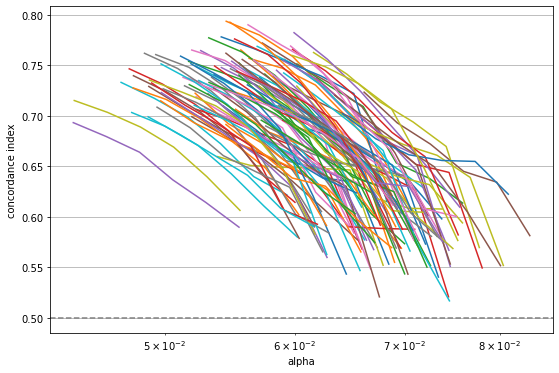

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
for i in range(Nsim):
  ax.plot(list_alphas_lasso[i], list_mean_lasso[i])
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)